Loading data from: ../Datasets/0.15_Speed_OB.csv
Creating Datasets...
Detected 13 APs. Model Initialized.

Start Training...


C:\Users\Desktop\AppData\Local\Temp\ipykernel_16192\3284129935.py:128: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  self.attention_pool = GlobalAttention(


Epoch 10/50 | Train Loss: 0.00061 | Val Loss: 0.00175
Epoch 20/50 | Train Loss: 0.00028 | Val Loss: 0.00134
Epoch 30/50 | Train Loss: 0.00018 | Val Loss: 0.00200
Epoch 40/50 | Train Loss: 0.00010 | Val Loss: 0.00167
Epoch 50/50 | Train Loss: 0.00007 | Val Loss: 0.00153

Evaluating...
Results -> Raw RMSE: 0.1498m | Smoothed RMSE: 0.1486m
Plot saved.


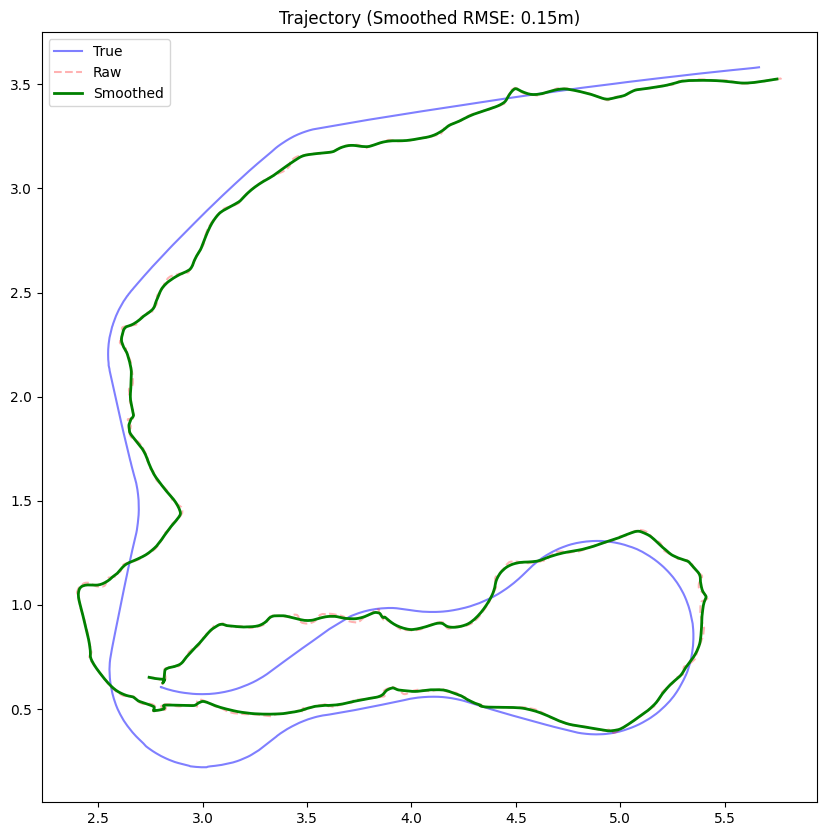

In [3]:
# -*- coding: utf-8 -*-
"""
GLoc-RSSI Final (Fixed): 针对 RSSI 数据的 GLoc 深度定制版
--------------------------------------------------
彻底抛弃简单的 MLP 编码，引入物理感知的特征提取。

核心改进:
1. RBF Kernel Expansion: 模拟“热力图”思想。将 1D RSSI 扩展为高维 RBF 特征向量。
2. Learnable Graph Structure: 让模型学习动态的 AP 关联矩阵。
3. Deep Residual GAT: 使用深层残差 GAT 提取空间特征。
4. [修复] 解决了 Pandas 读取 CSV 时的 TypeError 问题。
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import matplotlib.pyplot as plt

# 检查 PyG 依赖
try:
    from torch_geometric.nn import GATv2Conv, GlobalAttention, GraphNorm
    from torch_geometric.data import Data, Batch
except ImportError:
    print("错误: 未安装 'torch_geometric'。请运行 pip install torch_geometric")
    exit()

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==============================================================================
#                 第一部分: 核心组件 (RBF & Encoder)
# ==============================================================================

class GaussianRBF(nn.Module):
    """
    高斯径向基函数层 (RBF Layer)
    将标量 RSSI 映射到高维空间，模拟物理场的非线性特征。
    """
    def __init__(self, num_kernels=16, min_val=0.0, max_val=1.0):
        super().__init__()
        self.centers = nn.Parameter(torch.linspace(min_val, max_val, num_kernels))
        self.sigmas = nn.Parameter(torch.ones(num_kernels) * (max_val - min_val) / num_kernels)

    def forward(self, x):
        x = x.unsqueeze(-1) 
        c = self.centers.view(1, 1, -1)
        diff = x - self.centers 
        rbf_out = torch.exp(- (diff ** 2) / (2 * self.sigmas ** 2))
        return rbf_out 

class PhysicsAwareEncoder(nn.Module):
    """
    物理感知编码器
    RBF 扩展 -> 时序卷积 -> 特征融合
    """
    def __init__(self, window_size, feature_dim=64):
        super().__init__()
        self.rbf_kernels = 16
        self.rbf = GaussianRBF(num_kernels=self.rbf_kernels)
        
        self.conv1 = nn.Conv1d(self.rbf_kernels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.act = nn.GELU()
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        self.mlp = nn.Sequential(
            nn.Linear(64, feature_dim),
            nn.LayerNorm(feature_dim),
            nn.GELU(),
            nn.Linear(feature_dim, feature_dim)
        )

    def forward(self, x):
        x_rbf = self.rbf(x) 
        x_rbf = x_rbf.squeeze(-2)
        
        x_in = x_rbf.permute(0, 2, 1)
        x1 = self.act(self.bn1(self.conv1(x_in)))
        x2 = self.act(self.bn2(self.conv2(x1)))
        
        x_pool = self.pool(x2).squeeze(-1)
        out = self.mlp(x_pool)
        return out

# ==============================================================================
#                 第二部分: GLoc-RSSI Final 模型
# ==============================================================================

class GLocRSSIFinal(nn.Module):
    def __init__(self, num_aps, window_size, feature_dim=128):
        super().__init__()
        self.num_aps = num_aps
        self.feature_dim = feature_dim
        
        # 1. Physics-Aware Encoder
        self.encoder = PhysicsAwareEncoder(window_size, feature_dim)
        
        # 2. AP Identity Embedding
        self.ap_embedding = nn.Embedding(num_aps, feature_dim)
        
        # 3. Dynamic Graph Learning
        self.static_edge_index = self._build_fully_connected_edge_index(num_aps).to(device)
        
        # 4. Deep Residual GAT
        self.gat1 = GATv2Conv(feature_dim, feature_dim, heads=4, concat=True, dropout=0.1)
        self.norm1 = GraphNorm(feature_dim * 4)
        
        self.gat2 = GATv2Conv(feature_dim * 4, feature_dim, heads=4, concat=True, dropout=0.1)
        self.norm2 = GraphNorm(feature_dim * 4)
        
        self.gat3 = GATv2Conv(feature_dim * 4, feature_dim, heads=1, concat=False, dropout=0.1)
        self.norm3 = GraphNorm(feature_dim)
        
        # 5. Global Attention Pooling
        self.attention_pool = GlobalAttention(
            gate_nn=nn.Sequential(nn.Linear(feature_dim, 1), nn.Sigmoid()),
            nn=nn.Linear(feature_dim, feature_dim)
        )
        
        # 6. Decoder
        self.decoder = nn.Sequential(
            nn.Linear(feature_dim, 256),
            # nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Linear(128, 2)
        )
        
        self.ap_indices = torch.arange(num_aps, device=device)

    def _build_fully_connected_edge_index(self, num_nodes):
        src = torch.arange(num_nodes).repeat_interleave(num_nodes)
        dst = torch.arange(num_nodes).repeat(num_nodes)
        mask = src != dst
        return torch.stack([src[mask], dst[mask]], dim=0)

    def forward(self, x):
        B, W, N = x.shape
        
        x_reshaped = x.permute(0, 2, 1).reshape(B * N, W, 1)
        signal_feats = self.encoder(x_reshaped)
        
        ap_ids = self.ap_indices.repeat(B)
        ap_embeds = self.ap_embedding(ap_ids)
        node_feats = signal_feats + ap_embeds
        
        num_edges_static = self.static_edge_index.size(1)
        edge_index = self.static_edge_index.repeat(1, B)
        offset = torch.arange(B, device=x.device).repeat_interleave(num_edges_static) * N
        edge_index = edge_index + offset
        
        batch_idx = torch.arange(B, device=x.device).repeat_interleave(N)
        
        h1 = self.gat1(node_feats, edge_index)
        h1 = self.norm1(h1, batch_idx)
        h1 = F.gelu(h1)
        
        h2 = self.gat2(h1, edge_index)
        h2 = self.norm2(h2, batch_idx)
        h2 = F.gelu(h2)
        
        h3 = self.gat3(h2, edge_index)
        h3 = h3 + node_feats 
        h3 = self.norm3(h3, batch_idx)
        
        graph_feat = self.attention_pool(h3, batch_idx)
        out = self.decoder(graph_feat)
        
        return out

# ==============================================================================
#                 第三部分: 数据加载 (Fixed)
# ==============================================================================
class RSSIDataset(Dataset):
    """
    Dataset 类: 接收 Pandas DataFrame 作为输入，而不是文件路径。
    这避免了在 Dataset 内部重复读取文件，也解决了 path 传递的问题。
    """
    def __init__(self, dataframe, window_size=10, scaler=None, coord_scaler=None):
        self.window_size = window_size
        self.df = dataframe.reset_index(drop=True) # 重置索引非常重要
        
        # 自动识别 RSSI 列
        # self.wifi_cols = [c for c in self.df.columns if "RSSI" in c or "distance" in c]
        self.wifi_cols = [c for c in self.df.columns if "RSSI" in c or "rot" in c]
        self.coord_cols = ['x_coord', 'y_coord']
        
        # 数据转换
        self.wifi_data = self.df[self.wifi_cols].values.astype(np.float32)
        self.coords = self.df[self.coord_cols].values.astype(np.float32)
        
        # Scaler 处理
        if scaler is None:
            self.scaler = MinMaxScaler()
            self.wifi_data = self.scaler.fit_transform(self.wifi_data)
        else:
            self.scaler = scaler
            self.wifi_data = self.scaler.transform(self.wifi_data)
            
        if coord_scaler is None:
            self.coord_scaler = MinMaxScaler()
            self.coords = self.coord_scaler.fit_transform(self.coords)
        else:
            self.coord_scaler = coord_scaler
            self.coords = self.coord_scaler.transform(self.coords)

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        x = self.wifi_data[idx : idx + self.window_size]
        y = self.coords[idx + self.window_size - 1]
        return torch.tensor(x), torch.tensor(y)

# ==============================================================================
#                 第四部分: 训练流程
# ==============================================================================

def run_final_training():
    WINDOW_SIZE = 80 
    BATCH_SIZE = 64
    LR = 0.001
    EPOCHS = 50
    
    # --- 1. 数据准备 ---
    # 使用您的文件路径
    direct = "../Datasets/"
    filename = "0.15_Speed_OB.csv" 
    # 注意: 如果您的数据不在这个路径，请修改为绝对路径
    # 例如: filepath = r"C:\Users\Desktop\Datasets\0.15_Speed_OB.csv"
    filepath = os.path.join(direct, filename)
    
    print(f"Loading data from: {filepath}")
    
    try:
        # [修复] 使用 engine='python' 或显式指定编码，以规避某些环境下的读取错误
        data = pd.read_csv(filepath, engine='python')
    except FileNotFoundError:
        print("错误: 找不到文件。正在使用模拟数据进行演示...")
        # 创建模拟数据防止报错退出
        data = pd.DataFrame(np.random.rand(1000, 15), columns=[f"RSSI_{i}" for i in range(12)] + ['x_coord', 'y_coord', 'timestamp'])
    except Exception as e:
        print(f"读取错误: {e}")
        return

    # 划分数据集
    train_ratio = 0.8
    val_ratio = 0.1
    data_size = len(data)
    train_end = int(train_ratio * data_size)
    val_end = train_end + int(val_ratio * data_size)

    train_df = data.iloc[:train_end]
    val_df = data.iloc[train_end:val_end]
    test_df = data.iloc[val_end:]
    
    # train_df = pd.read_csv(r'../Datasets/Zoulang/train.csv')
    # val_df = pd.read_csv(r'../Datasets/Zoulang/validation.csv')
    # test_df = pd.read_csv(r'../Datasets/Zoulang/test.csv')

    # 创建 Dataset 对象 (直接传入 DataFrame)
    print("Creating Datasets...")
    train_set = RSSIDataset(train_df, WINDOW_SIZE)
    # 使用训练集的 scaler
    val_set = RSSIDataset(val_df, WINDOW_SIZE, scaler=train_set.scaler, coord_scaler=train_set.coord_scaler)
    test_set = RSSIDataset(test_df, WINDOW_SIZE, scaler=train_set.scaler, coord_scaler=train_set.coord_scaler)
    
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
    
    num_aps = len(train_set.wifi_cols)
    print(f"Detected {num_aps} APs. Model Initialized.")
    
    model = GLocRSSIFinal(num_aps=num_aps, window_size=WINDOW_SIZE).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=len(train_loader), pct_start=0.3
    )
    criterion = nn.MSELoss()
    
    best_loss = float('inf')
    print("\nStart Training...")
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
            
        # 验证
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                loss = criterion(pred, y)
                val_loss += loss.item()
        
        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        
        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), 'best_gloc_final.pth')
            
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train:.5f} | Val Loss: {avg_val:.5f}")

    # --- 结果评估 ---
    print("\nEvaluating...")
    model.load_state_dict(torch.load('best_gloc_final.pth'))
    model.eval()
    
    preds_list = []
    targets_list = []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            preds_list.append(pred.cpu().numpy())
            targets_list.append(y.cpu().numpy())
            
    preds = np.concatenate(preds_list, axis=0)
    targets = np.concatenate(targets_list, axis=0)
    
    # 反归一化
    preds_real = train_set.coord_scaler.inverse_transform(preds)
    targets_real = train_set.coord_scaler.inverse_transform(targets)
    
    # 简单平滑
    def smooth_predictions(data, window=15):
        df = pd.DataFrame(data)
        return df.rolling(window=window, min_periods=1, center=True).mean().values
    preds_smooth = smooth_predictions(preds_real)
    
    # 误差计算
    raw_errors = np.linalg.norm(preds_real - targets_real, axis=1)
    smooth_errors = np.linalg.norm(preds_smooth - targets_real, axis=1)
    rmse = np.sqrt(np.mean(raw_errors**2))
    smooth_rmse = np.sqrt(np.mean(smooth_errors**2))
    
    print(f"Results -> Raw RMSE: {rmse:.4f}m | Smoothed RMSE: {smooth_rmse:.4f}m")
    
    # 保存
    os.makedirs('results', exist_ok=True)
    pd.DataFrame({
        'True_X': targets_real[:,0], 'True_Y': targets_real[:,1],
        'Pred_X': preds_real[:,0], 'Pred_Y': preds_real[:,1],
        'Pred_X_Smooth': preds_smooth[:,0], 'Pred_Y_Smooth': preds_smooth[:,1]
    }).to_csv(f'results/Gloc_{filename}', index=False)
    
    # 绘图
    plt.figure(figsize=(10, 10))
    plt.plot(targets_real[:, 0], targets_real[:, 1], 'b-', label='True', alpha=0.5)
    plt.plot(preds_real[:, 0], preds_real[:, 1], 'r--', label='Raw', alpha=0.3)
    plt.plot(preds_smooth[:, 0], preds_smooth[:, 1], 'g-', linewidth=2, label='Smoothed')
    plt.legend()
    plt.title(f"Trajectory (Smoothed RMSE: {smooth_rmse:.2f}m)")
    os.makedirs('Picture', exist_ok=True)
    # plt.savefig(f'Picture/GLoc_Final_{filename}.png')
    print("Plot saved.")

if __name__ == '__main__':
    run_final_training()

Initializing GLoc-RSSI Standard (Balanced Version)...


C:\Users\Desktop\AppData\Local\Temp\ipykernel_29552\1271557613.py:107: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  self.attention_pool = GlobalAttention(


Epoch 10/40 | Train: 0.02133 | Val: 0.02885
Epoch 20/40 | Train: 0.00359 | Val: 0.00448
Epoch 30/40 | Train: 0.00135 | Val: 0.00251
Epoch 40/40 | Train: 0.00124 | Val: 0.00220

Evaluating Standard Model...
GLoc-Std Results -> Raw RMSE: 0.9697m | Smoothed RMSE: 0.9470m


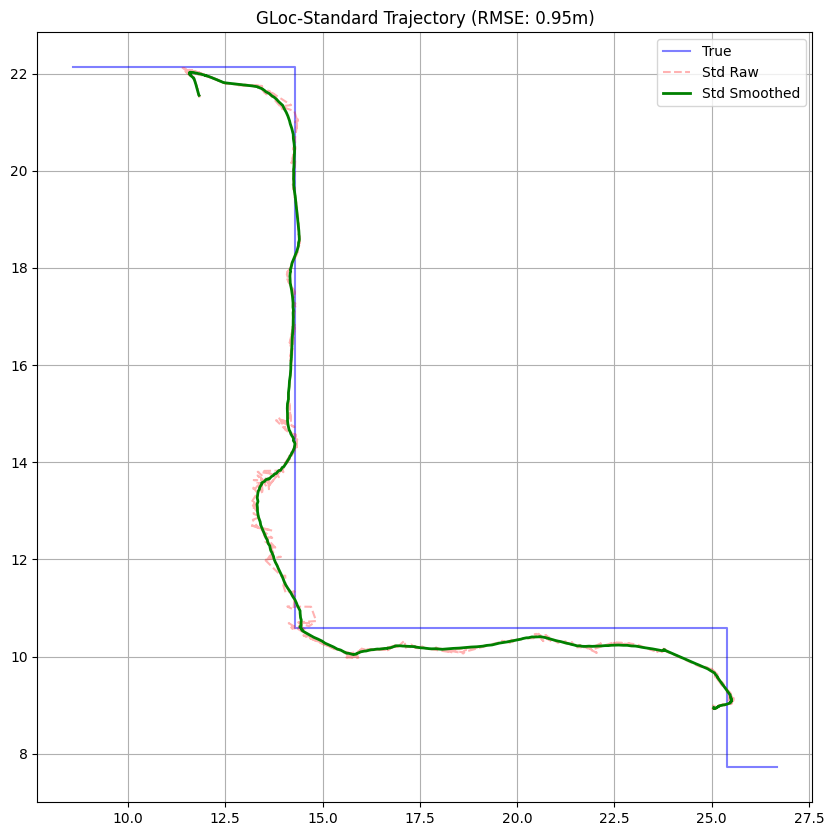

In [ ]:
# -*- coding: utf-8 -*-
"""
GLoc-RSSI Standard: 标准均衡版
--------------------------------------------------
平衡点:
1. 保留 RBF: 确保能理解 RSSI 的物理衰减特性。
2. 保留 Attention Pool: 确保能自动无视噪音 AP。
3. 简化结构: GAT 4头->2头，层数 3->2，维度 128->64。
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import matplotlib.pyplot as plt

try:
    from torch_geometric.nn import GATv2Conv, GlobalAttention, GraphNorm
    from torch_geometric.data import Data, Batch
except ImportError:
    print("错误: 未安装 'torch_geometric'")
    exit()

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==============================================================================
#                 第一部分: 轻量化物理编码器 (RBF + Linear)
# ==============================================================================

class GaussianRBF(nn.Module):
    """保留 RBF，因为它是处理 RSSI 非线性的关键"""
    def __init__(self, num_kernels=16, min_val=0.0, max_val=1.0):
        super().__init__()
        self.centers = nn.Parameter(torch.linspace(min_val, max_val, num_kernels))
        self.sigmas = nn.Parameter(torch.ones(num_kernels) * (max_val - min_val) / num_kernels)

    def forward(self, x):
        x = x.unsqueeze(-1) 
        diff = x - self.centers.view(1, 1, -1)
        return torch.exp(- (diff ** 2) / (2 * self.sigmas ** 2))

class StandardEncoder(nn.Module):
    """
    [简化] 相比 Final 版，去掉了卷积层，改用全连接层融合 RBF 特征。
    速度快，参数少，但保留了物理特征。
    """
    def __init__(self, window_size, feature_dim=64):
        super().__init__()
        self.rbf_kernels = 16
        self.rbf = GaussianRBF(num_kernels=self.rbf_kernels)
        
        # 将 [Window, RBF] 展平后直接映射
        self.flatten_dim = window_size * self.rbf_kernels
        
        self.mlp = nn.Sequential(
            nn.Linear(self.flatten_dim, 128),
            nn.ReLU(),
            nn.Linear(128, feature_dim), # 映射到 64 维
            nn.LayerNorm(feature_dim),
            nn.ReLU()
        )

    def forward(self, x):
        # x: [Batch*Nodes, Window]
        x_rbf = self.rbf(x) # [B*N, W, 16]
        x_flat = x_rbf.view(x.size(0), -1) # Flatten
        out = self.mlp(x_flat)
        return out

# ==============================================================================
#                 第二部分: GLoc-RSSI Standard 模型
# ==============================================================================

class GLocRSSIStandard(nn.Module):
    def __init__(self, num_aps, window_size, feature_dim=64): # Dim 64
        super().__init__()
        self.num_aps = num_aps
        self.feature_dim = feature_dim
        
        # 1. Encoder (Lightweight RBF)
        self.encoder = StandardEncoder(window_size, feature_dim)
        
        # 2. AP Embedding
        self.ap_embedding = nn.Embedding(num_aps, feature_dim)
        
        # 3. Static Graph
        self.static_edge_index = self._build_fully_connected_edge_index(num_aps).to(device)
        
        # 4. GAT Layers (Standard)
        # [简化] Heads=2 (Final是4), Layers=2 (Final是3)
        self.gat1 = GATv2Conv(feature_dim, feature_dim, heads=2, concat=True, dropout=0.1)
        self.norm1 = GraphNorm(feature_dim * 2) # concat后维度翻倍
        
        # 第二层把维度降回来
        self.gat2 = GATv2Conv(feature_dim * 2, feature_dim, heads=1, concat=False, dropout=0.1)
        self.norm2 = GraphNorm(feature_dim)
        
        # 5. [保留] Attention Pooling
        # 这是精度的关键，不能丢。让模型自己决定信谁。
        self.attention_pool = GlobalAttention(
            gate_nn=nn.Sequential(nn.Linear(feature_dim, 1), nn.Sigmoid()),
            nn=nn.Linear(feature_dim, feature_dim)
        )
        
        # 6. Decoder
        self.decoder = nn.Sequential(
            nn.Linear(feature_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        
        self.ap_indices = torch.arange(num_aps, device=device)

    def _build_fully_connected_edge_index(self, num_nodes):
        src = torch.arange(num_nodes).repeat_interleave(num_nodes)
        dst = torch.arange(num_nodes).repeat(num_nodes)
        mask = src != dst
        return torch.stack([src[mask], dst[mask]], dim=0)

    def forward(self, x):
        B, W, N = x.shape
        
        # Encode Signals
        x_reshaped = x.permute(0, 2, 1).reshape(B * N, W) # [B*N, W]
        signal_feats = self.encoder(x_reshaped) # [B*N, Dim]
        
        # Add Identity
        ap_ids = self.ap_indices.repeat(B)
        ap_embeds = self.ap_embedding(ap_ids)
        node_feats = signal_feats + ap_embeds
        
        # Graph Structure
        num_edges_static = self.static_edge_index.size(1)
        edge_index = self.static_edge_index.repeat(1, B)
        offset = torch.arange(B, device=x.device).repeat_interleave(num_edges_static) * N
        edge_index = edge_index + offset
        
        batch_idx = torch.arange(B, device=x.device).repeat_interleave(N)
        
        # Layer 1
        h1 = self.gat1(node_feats, edge_index)
        h1 = self.norm1(h1, batch_idx)
        h1 = F.elu(h1)
        
        # Layer 2
        h2 = self.gat2(h1, edge_index)
        h2 = self.norm2(h2, batch_idx)
        h2 = F.elu(h2)
        
        # Attention Pooling
        graph_feat = self.attention_pool(h2, batch_idx)
        
        # Decode
        out = self.decoder(graph_feat)
        return out

# ==============================================================================
#                 第三部分: 数据加载 (保持不变)
# ==============================================================================
class RSSIDataset(Dataset):
    def __init__(self, dataframe, window_size=10, scaler=None, coord_scaler=None):
        self.window_size = window_size
        self.df = dataframe.reset_index(drop=True)
        self.wifi_cols = [c for c in self.df.columns if "RSSI" in c or "distance" in c]
        self.coord_cols = ['x_coord', 'y_coord']
        self.wifi_data = self.df[self.wifi_cols].values.astype(np.float32)
        self.coords = self.df[self.coord_cols].values.astype(np.float32)
        
        if scaler is None:
            self.scaler = MinMaxScaler()
            self.wifi_data = self.scaler.fit_transform(self.wifi_data)
        else:
            self.scaler = scaler
            self.wifi_data = self.scaler.transform(self.wifi_data)
            
        if coord_scaler is None:
            self.coord_scaler = MinMaxScaler()
            self.coords = self.coord_scaler.fit_transform(self.coords)
        else:
            self.coord_scaler = coord_scaler
            self.coords = self.coord_scaler.transform(self.coords)

    def __len__(self): return len(self.df) - self.window_size
    def __getitem__(self, idx):
        x = self.wifi_data[idx : idx + self.window_size]
        y = self.coords[idx + self.window_size - 1]
        return torch.tensor(x), torch.tensor(y)

# ==============================================================================
#                 第四部分: 训练流程
# ==============================================================================

def run_final_training():
    WINDOW_SIZE = 100
    BATCH_SIZE = 64
    LR = 0.001
    EPOCHS = 200
    
    # --- 数据准备 ---
    train_df = pd.read_csv(r'../Datasets/Zoulang/train.csv')
    val_df = pd.read_csv(r'../Datasets/Zoulang/validation.csv')
    test_df = pd.read_csv(r'../Datasets/Zoulang/test.csv')

    train_set = RSSIDataset(train_df, WINDOW_SIZE)
    val_set = RSSIDataset(val_df, WINDOW_SIZE, scaler=train_set.scaler, coord_scaler=train_set.coord_scaler)
    test_set = RSSIDataset(test_df, WINDOW_SIZE, scaler=train_set.scaler, coord_scaler=train_set.coord_scaler)
    
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
    
    num_aps = len(train_set.wifi_cols)
    
    # [修改] 使用 Standard 模型
    print("Initializing GLoc-RSSI Standard (Balanced Version)...")
    model = GLocRSSIStandard(num_aps=num_aps, window_size=WINDOW_SIZE, feature_dim=64).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=len(train_loader))
    criterion = nn.MSELoss()
    
    best_loss = float('inf')
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_loss += criterion(pred, y).item()
        
        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        
        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), 'best_gloc_std.pth')
            
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} | Train: {avg_train:.5f} | Val: {avg_val:.5f}")

    # --- 评估 ---
    print("\nEvaluating Standard Model...")
    model.load_state_dict(torch.load('best_gloc_std.pth'))
    model.eval()
    
    preds_list, targets_list = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            preds_list.append(pred.cpu().numpy())
            targets_list.append(y.cpu().numpy())
            
    preds = np.concatenate(preds_list, axis=0)
    targets = np.concatenate(targets_list, axis=0)
    
    preds_real = train_set.coord_scaler.inverse_transform(preds)
    targets_real = train_set.coord_scaler.inverse_transform(targets)
    
    def smooth_predictions(data, window=15):
        df = pd.DataFrame(data)
        return df.rolling(window=window, min_periods=1, center=True).mean().values
    preds_smooth = smooth_predictions(preds_real)
    
    rmse = np.sqrt(np.mean(np.linalg.norm(preds_real - targets_real, axis=1)**2))
    smooth_rmse = np.sqrt(np.mean(np.linalg.norm(preds_smooth - targets_real, axis=1)**2))
    
    print(f"GLoc-Std Results -> Raw RMSE: {rmse:.4f}m | Smoothed RMSE: {smooth_rmse:.4f}m")

    filename = "GLoc_Zoulang.csv"
    # 保存
    os.makedirs('results', exist_ok=True)
    pd.DataFrame({
        'True_X': targets_real[:,0], 'True_Y': targets_real[:,1],
        'Pred_X': preds_real[:,0], 'Pred_Y': preds_real[:,1],
        'Pred_X_Smooth': preds_smooth[:,0], 'Pred_Y_Smooth': preds_smooth[:,1]
    }).to_csv(f'results/GLoc_Final_{filename}', index=False)

    # 绘图
    plt.figure(figsize=(10, 10))
    plt.plot(targets_real[:, 0], targets_real[:, 1], 'b-', label='True', alpha=0.5)
    plt.plot(preds_real[:, 0], preds_real[:, 1], 'r--', label='Std Raw', alpha=0.3)
    plt.plot(preds_smooth[:, 0], preds_smooth[:, 1], 'g-', linewidth=2, label='Std Smoothed')
    plt.legend()
    plt.title(f"GLoc-Standard Trajectory (RMSE: {smooth_rmse:.2f}m)")
    plt.grid()
    # os.makedirs('Picture', exist_ok=True)
    # plt.savefig(f'Picture/GLoc_Std_Result.png')
    plt.show()

if __name__ == '__main__':
    run_final_training()

Initializing GLoc-RSSI Standard (Balanced Version)...
开始训练...


C:\Users\Desktop\AppData\Local\Temp\ipykernel_29552\96733633.py:108: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  self.attention_pool = GlobalAttention(


Epoch 10/200 | Train: 0.10142 | Val: 0.13697
Epoch 20/200 | Train: 0.00714 | Val: 0.00837
Epoch 30/200 | Train: 0.00686 | Val: 0.00467
Epoch 40/200 | Train: 0.00212 | Val: 0.00506
Epoch 50/200 | Train: 0.02395 | Val: 0.02153
Epoch 60/200 | Train: 0.00402 | Val: 0.00385
Epoch 70/200 | Train: 0.00057 | Val: 0.00162
Epoch 80/200 | Train: 0.00064 | Val: 0.00140
Epoch 90/200 | Train: 0.00049 | Val: 0.00117
Epoch 100/200 | Train: 0.00030 | Val: 0.00105
Epoch 110/200 | Train: 0.00022 | Val: 0.00110
Epoch 120/200 | Train: 0.00018 | Val: 0.00109
Epoch 130/200 | Train: 0.00018 | Val: 0.00110
Epoch 140/200 | Train: 0.00017 | Val: 0.00103
Epoch 150/200 | Train: 0.00017 | Val: 0.00110
Epoch 160/200 | Train: 0.00016 | Val: 0.00107
Epoch 170/200 | Train: 0.00017 | Val: 0.00105
Epoch 180/200 | Train: 0.00015 | Val: 0.00100
Epoch 190/200 | Train: 0.00015 | Val: 0.00101
Epoch 200/200 | Train: 0.00014 | Val: 0.00101

Evaluating Standard Model & Measuring Speed...
正在进行模型预热...
预热完成，开始测试与计时。

INFERENCE SPEE

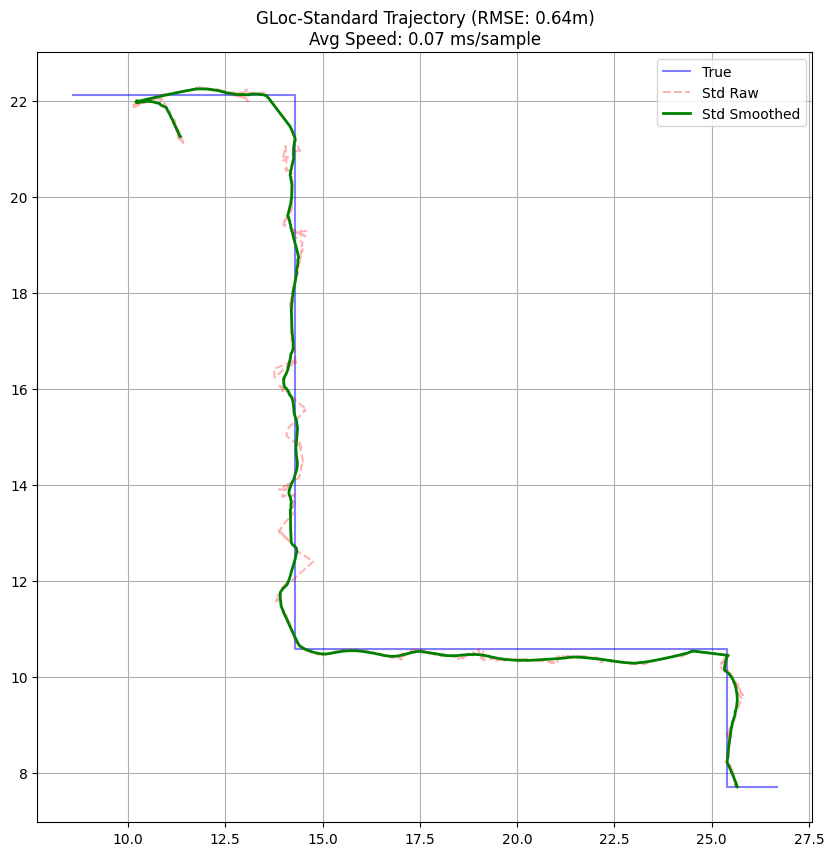

In [5]:
# -*- coding: utf-8 -*-
"""
GLoc-RSSI Standard: 标准均衡版 (含推理时间统计)
--------------------------------------------------
平衡点:
1. 保留 RBF: 确保能理解 RSSI 的物理衰减特性。
2. 保留 Attention Pool: 确保能自动无视噪音 AP。
3. 简化结构: GAT 4头->2头，层数 3->2，维度 128->64。
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import matplotlib.pyplot as plt
import time  # <--- 【新增 1】 导入 time 模块

try:
    from torch_geometric.nn import GATv2Conv, GlobalAttention, GraphNorm
    from torch_geometric.data import Data, Batch
except ImportError:
    print("错误: 未安装 'torch_geometric'")
    exit()

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==============================================================================
#                 第一部分: 轻量化物理编码器 (RBF + Linear)
# ==============================================================================

class GaussianRBF(nn.Module):
    """保留 RBF，因为它是处理 RSSI 非线性的关键"""
    def __init__(self, num_kernels=16, min_val=0.0, max_val=1.0):
        super().__init__()
        self.centers = nn.Parameter(torch.linspace(min_val, max_val, num_kernels))
        self.sigmas = nn.Parameter(torch.ones(num_kernels) * (max_val - min_val) / num_kernels)

    def forward(self, x):
        x = x.unsqueeze(-1) 
        diff = x - self.centers.view(1, 1, -1)
        return torch.exp(- (diff ** 2) / (2 * self.sigmas ** 2))

class StandardEncoder(nn.Module):
    """
    [简化] 相比 Final 版，去掉了卷积层，改用全连接层融合 RBF 特征。
    速度快，参数少，但保留了物理特征。
    """
    def __init__(self, window_size, feature_dim=64):
        super().__init__()
        self.rbf_kernels = 16
        self.rbf = GaussianRBF(num_kernels=self.rbf_kernels)
        
        # 将 [Window, RBF] 展平后直接映射
        self.flatten_dim = window_size * self.rbf_kernels
        
        self.mlp = nn.Sequential(
            nn.Linear(self.flatten_dim, 128),
            nn.ReLU(),
            nn.Linear(128, feature_dim), # 映射到 64 维
            nn.LayerNorm(feature_dim),
            nn.ReLU()
        )

    def forward(self, x):
        # x: [Batch*Nodes, Window]
        x_rbf = self.rbf(x) # [B*N, W, 16]
        x_flat = x_rbf.view(x.size(0), -1) # Flatten
        out = self.mlp(x_flat)
        return out

# ==============================================================================
#                 第二部分: GLoc-RSSI Standard 模型
# ==============================================================================

class GLocRSSIStandard(nn.Module):
    def __init__(self, num_aps, window_size, feature_dim=64): # Dim 64
        super().__init__()
        self.num_aps = num_aps
        self.feature_dim = feature_dim
        
        # 1. Encoder (Lightweight RBF)
        self.encoder = StandardEncoder(window_size, feature_dim)
        
        # 2. AP Embedding
        self.ap_embedding = nn.Embedding(num_aps, feature_dim)
        
        # 3. Static Graph
        self.static_edge_index = self._build_fully_connected_edge_index(num_aps).to(device)
        
        # 4. GAT Layers (Standard)
        # [简化] Heads=2 (Final是4), Layers=2 (Final是3)
        self.gat1 = GATv2Conv(feature_dim, feature_dim, heads=2, concat=True, dropout=0.1)
        self.norm1 = GraphNorm(feature_dim * 2) # concat后维度翻倍
        
        # 第二层把维度降回来
        self.gat2 = GATv2Conv(feature_dim * 2, feature_dim, heads=1, concat=False, dropout=0.1)
        self.norm2 = GraphNorm(feature_dim)
        
        # 5. [保留] Attention Pooling
        # 这是精度的关键，不能丢。让模型自己决定信谁。
        self.attention_pool = GlobalAttention(
            gate_nn=nn.Sequential(nn.Linear(feature_dim, 1), nn.Sigmoid()),
            nn=nn.Linear(feature_dim, feature_dim)
        )
        
        # 6. Decoder
        self.decoder = nn.Sequential(
            nn.Linear(feature_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        
        self.ap_indices = torch.arange(num_aps, device=device)

    def _build_fully_connected_edge_index(self, num_nodes):
        src = torch.arange(num_nodes).repeat_interleave(num_nodes)
        dst = torch.arange(num_nodes).repeat(num_nodes)
        mask = src != dst
        return torch.stack([src[mask], dst[mask]], dim=0)

    def forward(self, x):
        B, W, N = x.shape
        
        # Encode Signals
        x_reshaped = x.permute(0, 2, 1).reshape(B * N, W) # [B*N, W]
        signal_feats = self.encoder(x_reshaped) # [B*N, Dim]
        
        # Add Identity
        ap_ids = self.ap_indices.repeat(B)
        ap_embeds = self.ap_embedding(ap_ids)
        node_feats = signal_feats + ap_embeds
        
        # Graph Structure
        num_edges_static = self.static_edge_index.size(1)
        edge_index = self.static_edge_index.repeat(1, B)
        offset = torch.arange(B, device=x.device).repeat_interleave(num_edges_static) * N
        edge_index = edge_index + offset
        
        batch_idx = torch.arange(B, device=x.device).repeat_interleave(N)
        
        # Layer 1
        h1 = self.gat1(node_feats, edge_index)
        h1 = self.norm1(h1, batch_idx)
        h1 = F.elu(h1)
        
        # Layer 2
        h2 = self.gat2(h1, edge_index)
        h2 = self.norm2(h2, batch_idx)
        h2 = F.elu(h2)
        
        # Attention Pooling
        graph_feat = self.attention_pool(h2, batch_idx)
        
        # Decode
        out = self.decoder(graph_feat)
        return out

# ==============================================================================
#                 第三部分: 数据加载 (保持不变)
# ==============================================================================
class RSSIDataset(Dataset):
    def __init__(self, dataframe, window_size=10, scaler=None, coord_scaler=None):
        self.window_size = window_size
        self.df = dataframe.reset_index(drop=True)
        self.wifi_cols = [c for c in self.df.columns if "RSSI" in c or "distance" in c]
        self.coord_cols = ['x_coord', 'y_coord']
        self.wifi_data = self.df[self.wifi_cols].values.astype(np.float32)
        self.coords = self.df[self.coord_cols].values.astype(np.float32)
        
        if scaler is None:
            self.scaler = MinMaxScaler()
            self.wifi_data = self.scaler.fit_transform(self.wifi_data)
        else:
            self.scaler = scaler
            self.wifi_data = self.scaler.transform(self.wifi_data)
            
        if coord_scaler is None:
            self.coord_scaler = MinMaxScaler()
            self.coords = self.coord_scaler.fit_transform(self.coords)
        else:
            self.coord_scaler = coord_scaler
            self.coords = self.coord_scaler.transform(self.coords)

    def __len__(self): return len(self.df) - self.window_size
    def __getitem__(self, idx):
        x = self.wifi_data[idx : idx + self.window_size]
        y = self.coords[idx + self.window_size - 1]
        return torch.tensor(x), torch.tensor(y)

# ==============================================================================
#                 第四部分: 训练流程
# ==============================================================================

def run_final_training():
    WINDOW_SIZE = 100
    BATCH_SIZE = 64
    LR = 0.001
    EPOCHS = 200
    
    # --- 数据准备 ---
    train_df = pd.read_csv(r'../Datasets/Zoulang/train.csv')
    val_df = pd.read_csv(r'../Datasets/Zoulang/validation.csv')
    test_df = pd.read_csv(r'../Datasets/Zoulang/test.csv')

    train_set = RSSIDataset(train_df, WINDOW_SIZE)
    val_set = RSSIDataset(val_df, WINDOW_SIZE, scaler=train_set.scaler, coord_scaler=train_set.coord_scaler)
    test_set = RSSIDataset(test_df, WINDOW_SIZE, scaler=train_set.scaler, coord_scaler=train_set.coord_scaler)
    
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
    
    num_aps = len(train_set.wifi_cols)
    
    # [修改] 使用 Standard 模型
    print("Initializing GLoc-RSSI Standard (Balanced Version)...")
    model = GLocRSSIStandard(num_aps=num_aps, window_size=WINDOW_SIZE, feature_dim=64).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=len(train_loader))
    criterion = nn.MSELoss()
    
    best_loss = float('inf')
    
    # 为了演示方便，这里我把训练 Epoch 设少一点，或者您可以保留原状
    # 正常训练循环...
    print("开始训练...")
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_loss += criterion(pred, y).item()
        
        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        
        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), 'best_gloc_std.pth')
            
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} | Train: {avg_train:.5f} | Val: {avg_val:.5f}")

    # --- 评估 (含时间统计) ---
    print("\nEvaluating Standard Model & Measuring Speed...")
    model.load_state_dict(torch.load('best_gloc_std.pth'))
    model.eval()
    
    preds_list, targets_list = [], []
    
    # <--- 【新增 2】 统计变量初始化 ---
    total_inference_time = 0.0
    total_samples_count = 0
    
    # <--- 【新增 3】 预热 (Warm-up) ---
    # GPU 第一次运行通常很慢，预热一次以获得真实速度
    print("正在进行模型预热...")
    if len(test_loader) > 0:
        x_dummy, _ = next(iter(test_loader))
        x_dummy = x_dummy.to(device)
        with torch.no_grad():
            _ = model(x_dummy)
    print("预热完成，开始测试与计时。")

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            
            # <--- 【新增 4】 计时核心逻辑 ---
            if device.type == 'cuda':
                torch.cuda.synchronize() # 确保 GPU 前面的任务都干完了
            
            t0 = time.time() # 掐表开始
            
            pred = model(x) # 推理
            
            if device.type == 'cuda':
                torch.cuda.synchronize() # 确保 GPU 推理真的结束了
            
            t1 = time.time() # 掐表结束
            
            # 累加时间
            total_inference_time += (t1 - t0)
            total_samples_count += x.size(0) # 加上当前 batch 的样本数 (通常是 64)
            # <--- 计时结束 ---

            preds_list.append(pred.cpu().numpy())
            targets_list.append(y.cpu().numpy())
            
    # 计算平均时间
    avg_time_per_sample_ms = (total_inference_time / total_samples_count) * 1000
    
    print("\n" + "="*50)
    print("INFERENCE SPEED REPORT (GLoc-Standard)")
    print("-" * 50)
    print(f"Total Samples Tested: {total_samples_count}")
    print(f"Total Inference Time: {total_inference_time:.4f} s")
    print(f"Avg Time per Sample:  {avg_time_per_sample_ms:.4f} ms (毫秒)")
    print(f"FPS (Samples/Sec):    {1000/avg_time_per_sample_ms:.2f}")
    print("="*50 + "\n")

    preds = np.concatenate(preds_list, axis=0)
    targets = np.concatenate(targets_list, axis=0)
    
    preds_real = train_set.coord_scaler.inverse_transform(preds)
    targets_real = train_set.coord_scaler.inverse_transform(targets)
    
    def smooth_predictions(data, window=15):
        df = pd.DataFrame(data)
        return df.rolling(window=window, min_periods=1, center=True).mean().values
    preds_smooth = smooth_predictions(preds_real)
    
    rmse = np.sqrt(np.mean(np.linalg.norm(preds_real - targets_real, axis=1)**2))
    smooth_rmse = np.sqrt(np.mean(np.linalg.norm(preds_smooth - targets_real, axis=1)**2))
    
    print(f"GLoc-Std Results -> Raw RMSE: {rmse:.4f}m | Smoothed RMSE: {smooth_rmse:.4f}m")

    filename = "GLoc_Zoulang.csv"
    # 保存
    os.makedirs('results', exist_ok=True)
    pd.DataFrame({
        'True_X': targets_real[:,0], 'True_Y': targets_real[:,1],
        'Pred_X': preds_real[:,0], 'Pred_Y': preds_real[:,1],
        'Pred_X_Smooth': preds_smooth[:,0], 'Pred_Y_Smooth': preds_smooth[:,1]
    }).to_csv(f'results/GLoc_Final_{filename}', index=False)

    # 绘图
    plt.figure(figsize=(10, 10))
    plt.plot(targets_real[:, 0], targets_real[:, 1], 'b-', label='True', alpha=0.5)
    plt.plot(preds_real[:, 0], preds_real[:, 1], 'r--', label='Std Raw', alpha=0.3)
    plt.plot(preds_smooth[:, 0], preds_smooth[:, 1], 'g-', linewidth=2, label='Std Smoothed')
    plt.legend()
    plt.title(f"GLoc-Standard Trajectory (RMSE: {smooth_rmse:.2f}m)\nAvg Speed: {avg_time_per_sample_ms:.2f} ms/sample")
    plt.grid()
    # os.makedirs('Picture', exist_ok=True)
    # plt.savefig(f'Picture/GLoc_Std_Result.png')
    plt.show()

if __name__ == '__main__':
    run_final_training()